In [2]:
import gdal
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import segmentation
import torch
import torch.nn as nn
#from mylib import *

In [20]:
def getBands(filename):
    img = gdal.Open(filename)
    bands = []
    for i in range(img.RasterCount):
        band = img.GetRasterBand(i+1).ReadAsArray().astype(np.float)
        bands.append(band)
    bands = np.dstack((bands[0],bands[1],bands[2],bands[3]))
    return bands
def maxminNorm(data):
    '''
    01标准化
    '''
    data=data.astype(np.float32)
    dmax=data.max()
    dmin=data.min()
    return (data-data.min())/(dmax-dmin)

def rgbNorm(data):
    '''
    01标准化
    '''
    data=data.astype(np.float32)
    dmax=data.max()
    dmin=data.min()
    dst=(data-data.min())/(dmax-dmin)*255
    dst=dst+0.5
    return dst.astype(np.uint8)


def index(data,ind="NDVI"):
    '''
    input:原始数据，默认保持影像形状，默认计算NDVI
    returns:相应指数
    '''
    nir=data[:,:,3]
    red=data[:,:,2]
    grn=data[:,:,1]
    blue=data[:,:,0]
    if ind=="NDVI":# 归一化植被指数 
        NDVI=(nir-red)/(nir+red+1e-8)
        return NDVI
    elif ind=="NDWI":# 归一化水体指数
        NDWI=(grn-nir)/(grn+nir+1e-8)
        return NDWI
    elif ind=="CIg":# 叶绿素指数-绿边 
        CIg=nir/(grn+1e-8)-1
        return CIg
    elif ind=="EVI":# 增强型植被指数 
        EVI=2.5*(nir-red)/(nir+ 6*red-7.5*blue+1+1e-8)
        return EVI
    elif ind=="GNDVI":# 绿光归一化差值植被指数
        GNDVI = (nir - grn)/(nir + grn+1e-8)
        return GNDVI
    elif ind=="MSAVI":# 修正土壤调节植被指数
        MSAVI=0.5*(2*(nir +1)-np.sqrt((2*nir+1)**2-8*(nir-red)))
        return MSAVI
    elif ind=="MTVI":# 修正型三角植被指数
        MTVI=1.5*(1.2*(nir-grn)-2.5*(red-grn))/np.sqrt((2*nir+1)**2-(6*nir-5*np.sqrt(red))-0.5)
        return MTVI
    elif ind=="SAVI":# 土壤调节植被指数
        L=0.5
        SAVI=((nir-red)/(nir+red+L))*(1+L)
        return SAVI
    elif ind=="VARI":# 可视化大气阻抗指数
        VARI=(grn-red)/(grn+red-blue+1e-8)
        return VARI
    
def returnLabeldata(data,indexName,df=False,reshape=True,norm=False):
    h,w,d=data.shape
    dataIdx=np.zeros((data.shape[0],data.shape[1],len(indexName)),dtype=np.float32)
    for i,idx in enumerate(indexName):
        if norm==True:
            dataIdx[:,:,i]=maxminNorm(index(data,ind=idx))
        else:
            dataIdx[:,:,i]=index(data,ind=idx)
    if len(np.unique(np.argwhere(np.isnan(dataIdx))[:,2]))!=0:
        print(np.unique(np.argwhere(np.isnan(dataIdx))[:,2]))
    if df==True:
        res=pd.DataFrame(dataIdx.reshape((h*w,-1)),columns=indexName)
    if reshape==True:
        res=dataIdx.reshape((h*w,-1))
    else:
        res=dataIdx
    return res

def addY(loc,data,nums):#data3维
    loc=loc.astype(np.int)
    y=np.zeros((sum(nums),1))
    s=0
    for i,num in enumerate(nums):
        y[s:s+num,0]=i
    x=np.zeros((sum(nums),data.shape[2]))
    for i,yx in enumerate(loc):
        x[i,:]=data[yx[1],yx[0],:]
    train=np.concatenate((x,y),axis=1)
    return train
def to01234(im):
    lab=np.unique(im)
    for i in range(5):
        im[im==lab[i]]=i*50
    for i in range(5):
        im[im==i*50]=i
    lab=np.histogram(im,[0,1,2,3,4,5])[0].argsort()
    for i in range(5):
        im[im==lab[i]]=(i+1)*50
    for i in range(5):
        im[im==(i+1)*50]=i
    return im
def color(y_pred):
    show=np.zeros((y_pred.shape[0],y_pred.shape[1],3))
    cmap=np.array([[0,255,0],[255,255,0],[0,0,255],[255,0,0],[0,255,255]])
    for i in range(5):
        show[y_pred==i,:]=cmap[i]
    return show

In [15]:
class Args(object):
    def __init__(self,epoch=64,labelNum=5):
        #self.input_image_path = path  # image/coral.jpg image/tiger.jpg
        self.train_epoch = epoch 
        self.mod_dim1 = 64  #
        self.mod_dim2 = 32

        self.min_label_num = labelNum  # if the label number small than it, break loop
        self.max_label_num = 256  # if the label number small than it, start to show result image.

class MyNet(nn.Module):
    def __init__(self, inp_dim, mod_dim1, mod_dim2):
        super(MyNet, self).__init__()

        self.seq = nn.Sequential(
            
            nn.Conv2d(inp_dim, mod_dim1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mod_dim1),
            nn.ReLU(inplace=True),

            nn.Conv2d(mod_dim1, mod_dim2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mod_dim2),
            nn.ReLU(inplace=True),

            nn.Conv2d(mod_dim2, mod_dim1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mod_dim1),
            nn.ReLU(inplace=True),

            nn.Conv2d(mod_dim1, mod_dim2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(mod_dim2),
        )

    def forward(self, x):
        return self.seq(x)


def run(image,epoch):
    args = Args(epoch)
    torch.cuda.manual_seed_all(1023)
    np.random.seed(1023)
    
    '''segmentation ML'''
    seg_map = segmentation.felzenszwalb(image[:,:,:3], scale=32, sigma=0.5, min_size=64)
    seg_map = seg_map.flatten()
    seg_lab = [np.where(seg_map == u_label)[0]
               for u_label in np.unique(seg_map)]

    '''train init'''
    device = torch.device('cpu')
    tensor = image.transpose((2,0,1))
    tensor = tensor.astype(np.float32) / image.max()
    tensor = tensor[np.newaxis, :, :, :]
    tensor = torch.from_numpy(tensor).to(device)
    
    #维度注意，对应通道数inp_dim
    model = MyNet(inp_dim=7, mod_dim1=args.mod_dim1, mod_dim2=args.mod_dim2).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)

    image_flatten = image.reshape((-1, 7))
    show = image

    '''train loop'''
    model.train()
    for batch_idx in range(args.train_epoch):
        '''forward'''
        optimizer.zero_grad()
        output = model(tensor)[0]
        output = output.permute(1, 2, 0).view(-1, args.mod_dim2)
        target = torch.argmax(output, 1)
        im_target = target.data.cpu().numpy()

        '''refine'''
        for inds in seg_lab:
            u_labels, hist = np.unique(im_target[inds], return_counts=True)
            im_target[inds] = u_labels[np.argmax(hist)]

        '''backward'''
        target = torch.from_numpy(im_target)
        target = target.to(device)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        
        if np.unique(im_target).shape[0]==5:
            break
        if batch_idx%16==0:
            print("%d次:%.2f"%(batch_idx,loss))
    return im_target

In [34]:
# prepare data
path=r"E:\project\images\sentinal"
img1=getBands(os.path.join(path,"171009.tif"))
img2=getBands(os.path.join(path,"190919.tif"))
data1=img1#[600:1000,600:1000,:]
data2=img2#[600:1000,600:1000,:]
indexName=["NDVI","NDWI","MSAVI","MTVI","VARI"]
labdata1=returnLabeldata(data1,indexName,reshape=False)
labdata2=returnLabeldata(data2,indexName,reshape=False)
data1norm=maxminNorm(data1)
data2norm=maxminNorm(data2)
labdata1norm=maxminNorm(labdata1)
labdata2norm=maxminNorm(labdata2)
data1total=np.concatenate((data1norm,labdata1norm),axis=2)
data2total=np.concatenate((data2norm,labdata2norm),axis=2)

In [29]:
im1=to01234(im1)
im2=to01234(im2)
pre1=im1.reshape((653,772))
pre2=im2.reshape((653,772))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 771.5, 652.5, -0.5)

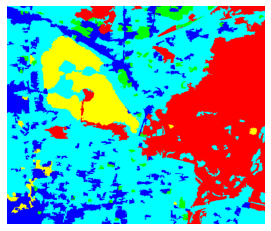

In [30]:
#im1=run(data1total,64)
plt.imshow(color(pre1))
plt.axis('off')
#cv2.imwrite(r"E:\project\images\researchImage\HR\output\1.jpg",im1.reshape((400,400)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 771.5, 652.5, -0.5)

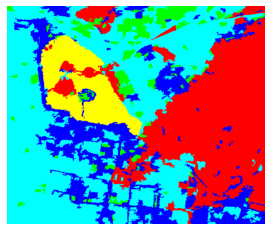

In [31]:
#im2=run(data2total,64)
# pre2[pre2==0]=100
# pre2[pre2==2]=0
# pre2[pre2==100]=2
plt.imshow(color(pre2))
plt.axis('off')
#cv2.imwrite(r"E:\project\images\researchImage\HR\output\3.jpg",im2.reshape((400,400)))

In [32]:
def genmask(pre1,pre2):
    h,w=653,772
    size=3
    mask=np.ones((h,w),dtype=np.int)
    for i in range(h//size):
        for j in range(w//size):
            if np.any(pre1[i*size:(i+1)*size,j*size:(j+1)*size]-pre2[i*size:(i+1)*size,j*size:(j+1)*size]!=0):
                mask[i*size:(i+1)*size,j*size:(j+1)*size]=0
    return mask

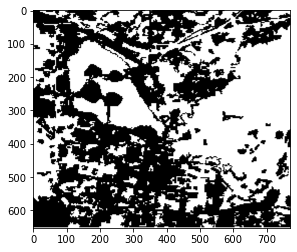

In [37]:
mask=genmask(pre1,pre2)
plt.imshow(mask,'gray')

In [40]:
diff=np.sqrt(np.sum((data1total-data2total)**2,axis=2))
h,w=653,772
size=3
for i in range(h//size):
    for j in range(w//size):
        if np.all(mask[i*size:(i+1)*size,j*size:(j+1)*size]==0):
            if np.all(diff[i*size:(i+1)*size,j*size:(j+1)*size]<0.5):
                mask[i*size:(i+1)*size,j*size:(j+1)*size]=1

(-0.5, 771.5, 652.5, -0.5)

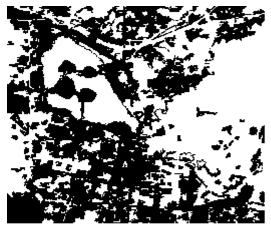

In [41]:
plt.imshow(mask,'gray')
plt.axis('off')

In [42]:
cv2.imwrite(r"E:\project\images\sentinal\process\label\mask.tif",mask)
#cv2.imwrite(r"E:\project\images\researchImage\HR\label\unmask1.tif",unmask1)

True

In [43]:
rgb19=cv2.imread(r"E:\project\images\sentinal\process\label\rgb19.tif")
rgb17=cv2.imread(r"E:\project\images\sentinal\process\label\rgb17.tif")

In [44]:
rgb19mask=rgb19.copy()
rgb19unmask=rgb19.copy()
rgb19mask[mask==1]=np.array([255,255,255])
rgb19mask=rgb19mask.astype(np.uint8)
rgb19unmask[mask==0]=np.array([255,255,255])
rgb19unmask=rgb19unmask.astype(np.uint8)
rgb17mask=rgb17.copy()
rgb17unmask=rgb17.copy()
rgb17mask[mask==1]=np.array([255,255,255])
rgb17mask=rgb17mask.astype(np.uint8)
rgb17unmask[mask==0]=np.array([255,255,255])
rgb17unmask=rgb17unmask.astype(np.uint8)

In [46]:
cv2.imwrite(r"E:\project\images\sentinal\process\label\rgb19mask.tif",rgb19mask)
cv2.imwrite(r"E:\project\images\sentinal\process\label\rgb19unmask.tif",rgb19unmask)

True

In [45]:
cv2.imwrite(r"E:\project\images\sentinal\process\label\rgb17mask.tif",rgb17mask)
cv2.imwrite(r"E:\project\images\sentinal\process\label\rgb17unmask.tif",rgb17unmask)

True

In [35]:
cv2.imwrite(r"E:\project\images\sentinal\process\label\rgb17.tif",rgbNorm(img1[:,:,:3]))
cv2.imwrite(r"E:\project\images\sentinal\process\label\rgb19.tif",rgbNorm(img2[:,:,:3]))

True

In [27]:
# prepare data
class1=cv2.imread(r"E:\project\images\sentinal\process\output\cotrain\sample200epoch20size20class17.jpg")
class2=cv2.imread(r"E:\project\images\sentinal\process\output\cotrain\sample200epoch20size20class19.jpg")

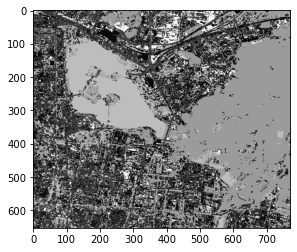